In [1]:
!pip install optuna optuna-integration

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 13.7 MB/s eta 0:00:00


# Importing necessary Libraries

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import optuna
from optuna_integration import TFKerasPruningCallback
import string

# Set seeds for reproducibility


In [3]:
tf.random.set_seed(200)
np.random.seed(200)

# Load data


In [ ]:
article_df = pd.read_csv("ArticlesMarch2018.csv")
all_headlines = [h for h in article_df.headline.values if h != "Unknown"]

# Pre-processing functions

In [ ]:
def clean_text(txt):
    return "".join(v for v in txt.lower() if v not in string.punctuation)

corpus = [clean_text(x) for x in all_headlines]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

def create_sequences(tokenizer, corpus):
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
    label = to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

# Creating the Model

In [ ]:
predictors, label, max_sequence_len = create_sequences(tokenizer, corpus)

def build_and_compile_model(input_len, total_words):
    global model
    model = Sequential([
        Embedding(total_words, 32, input_length=input_len),
        SimpleRNN(200, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        SimpleRNN(200),
        Dropout(0.2),
        Dense(total_words, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
def objective(trial):
    # Define the hyperparameters
    rnn_units = trial.suggest_categorical("rnn_units", [50, 100, 200])
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Model building
    model = build_and_compile_model(max_sequence_len-1, total_words)

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True),
        TFKerasPruningCallback(trial, "val_accuracy"),
        TensorBoard(log_dir='./logs')
    ]

    # Model training
    history = model.fit(predictors, label, epochs=25, batch_size=batch_size, validation_split=0.2, callbacks=callbacks, verbose=1)
    return history.history['val_accuracy'][-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_rnn_units = study.best_params['rnn_units']
best_dropout_rate = study.best_params['dropout_rate']
best_batch_size = study.best_params['batch_size']

print(f"Best parameters - RNN Units: {best_rnn_units}, Dropout Rate: {best_dropout_rate}, Batch Size: {best_batch_size}")

[I 2024-05-11 03:33:03,721] A new study created in memory with name: no-name-9c32f1c3-4291-4dc5-a57b-ae47debd00f7
<ipython-input-8-b94bd048c276>:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)


Epoch 1/25
51/51 [==============================] - 9s 119ms/step - loss: 7.6769 - accuracy: 0.0290 - val_loss: 7.6843 - val_accuracy: 0.0335
Epoch 2/25
51/51 [==============================] - 7s 141ms/step - loss: 7.1660 - accuracy: 0.0307 - val_loss: 7.8050 - val_accuracy: 0.0335
Epoch 3/25
51/51 [==============================] - 5s 93ms/step - loss: 7.1099 - accuracy: 0.0296 - val_loss: 7.8358 - val_accuracy: 0.0335
Epoch 4/25
51/51 [==============================] - 5s 91ms/step - loss: 7.0534 - accuracy: 0.0316 - val_loss: 7.9131 - val_accuracy: 0.0347
Epoch 4: early stopping


[I 2024-05-11 03:33:30,419] Trial 0 finished with value: 0.03471791744232178 and parameters: {'rnn_units': 100, 'dropout_rate': 0.41517635278342324, 'batch_size': 128}. Best is trial 0 with value: 0.03471791744232178.


Epoch 1/25
51/51 [==============================] - 9s 113ms/step - loss: 7.6824 - accuracy: 0.0228 - val_loss: 7.6241 - val_accuracy: 0.0335
Epoch 2/25
51/51 [==============================] - 5s 91ms/step - loss: 7.1682 - accuracy: 0.0304 - val_loss: 7.7856 - val_accuracy: 0.0335
Epoch 3/25
51/51 [==============================] - 6s 113ms/step - loss: 7.1329 - accuracy: 0.0316 - val_loss: 7.8846 - val_accuracy: 0.0174
Epoch 4/25
51/51 [==============================] - 5s 91ms/step - loss: 7.0147 - accuracy: 0.0346 - val_loss: 8.0444 - val_accuracy: 0.0248
Epoch 4: early stopping


[I 2024-05-11 03:33:54,410] Trial 1 finished with value: 0.02479851245880127 and parameters: {'rnn_units': 50, 'dropout_rate': 0.441320788833541, 'batch_size': 128}. Best is trial 0 with value: 0.03471791744232178.


Epoch 1/25
51/51 [==============================] - 7s 100ms/step - loss: 7.6702 - accuracy: 0.0253 - val_loss: 7.6717 - val_accuracy: 0.0335
Epoch 2/25
51/51 [==============================] - 6s 120ms/step - loss: 7.1754 - accuracy: 0.0322 - val_loss: 7.8569 - val_accuracy: 0.0335
Epoch 3/25
51/51 [==============================] - 5s 90ms/step - loss: 7.1047 - accuracy: 0.0321 - val_loss: 7.8310 - val_accuracy: 0.0174
Epoch 4/25
51/51 [==============================] - 6s 110ms/step - loss: 7.0096 - accuracy: 0.0349 - val_loss: 7.8665 - val_accuracy: 0.0298
Epoch 4: early stopping


[I 2024-05-11 03:34:38,411] Trial 2 finished with value: 0.029758214950561523 and parameters: {'rnn_units': 100, 'dropout_rate': 0.24716328334915702, 'batch_size': 128}. Best is trial 0 with value: 0.03471791744232178.


Epoch 1/25
202/202 [==============================] - 13s 49ms/step - loss: 7.6711 - accuracy: 0.0287 - val_loss: 7.7613 - val_accuracy: 0.0335
Epoch 2/25
202/202 [==============================] - 9s 44ms/step - loss: 7.2194 - accuracy: 0.0301 - val_loss: 7.9172 - val_accuracy: 0.0322
Epoch 3/25
202/202 [==============================] - 8s 38ms/step - loss: 6.9924 - accuracy: 0.0400 - val_loss: 8.0195 - val_accuracy: 0.0112
Epoch 4/25
202/202 [==============================] - 9s 45ms/step - loss: 6.7024 - accuracy: 0.0422 - val_loss: 7.8675 - val_accuracy: 0.0378
Epoch 4: early stopping


[I 2024-05-11 03:35:37,359] Trial 3 finished with value: 0.037817731499671936 and parameters: {'rnn_units': 200, 'dropout_rate': 0.2965342018558983, 'batch_size': 32}. Best is trial 3 with value: 0.037817731499671936.


Epoch 1/25
51/51 [==============================] - 8s 95ms/step - loss: 7.6698 - accuracy: 0.0257 - val_loss: 7.6791 - val_accuracy: 0.0335
Epoch 2/25
51/51 [==============================] - 5s 100ms/step - loss: 7.1728 - accuracy: 0.0304 - val_loss: 7.8073 - val_accuracy: 0.0335
Epoch 3/25
51/51 [==============================] - 5s 106ms/step - loss: 7.1052 - accuracy: 0.0276 - val_loss: 7.8596 - val_accuracy: 0.0335
Epoch 4/25
51/51 [==============================] - 5s 93ms/step - loss: 6.9746 - accuracy: 0.0339 - val_loss: 8.0402 - val_accuracy: 0.0335
Epoch 4: early stopping


[I 2024-05-11 03:36:06,425] Trial 4 finished with value: 0.033477991819381714 and parameters: {'rnn_units': 200, 'dropout_rate': 0.38622771399715494, 'batch_size': 128}. Best is trial 3 with value: 0.037817731499671936.


Epoch 1/25
100/101 [============================>.] - ETA: 0s - loss: 7.6481 - accuracy: 0.0262

[I 2024-05-11 03:36:16,388] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/25
51/51 [==============================] - 9s 109ms/step - loss: 7.6576 - accuracy: 0.0276 - val_loss: 7.6737 - val_accuracy: 0.0335
Epoch 2/25
51/51 [==============================] - 4s 85ms/step - loss: 7.1803 - accuracy: 0.0307 - val_loss: 7.8421 - val_accuracy: 0.0335
Epoch 3/25
51/51 [==============================] - 6s 111ms/step - loss: 7.1327 - accuracy: 0.0290 - val_loss: 7.9302 - val_accuracy: 0.0335
Epoch 4/25
51/51 [==============================] - 5s 91ms/step - loss: 7.0260 - accuracy: 0.0356 - val_loss: 8.1146 - val_accuracy: 0.0341
Epoch 4: early stopping


[I 2024-05-11 03:36:43,266] Trial 6 finished with value: 0.034097954630851746 and parameters: {'rnn_units': 200, 'dropout_rate': 0.3728357112324686, 'batch_size': 128}. Best is trial 3 with value: 0.037817731499671936.


Epoch 1/25
202/202 [==============================] - 12s 47ms/step - loss: 7.6814 - accuracy: 0.0281 - val_loss: 7.7341 - val_accuracy: 0.0335
Epoch 2/25
202/202 [==============================] - 9s 45ms/step - loss: 7.2258 - accuracy: 0.0310 - val_loss: 7.9816 - val_accuracy: 0.0167
Epoch 3/25
202/202 [==============================] - 8s 38ms/step - loss: 7.0104 - accuracy: 0.0398 - val_loss: 8.1888 - val_accuracy: 0.0050
Epoch 4/25
201/202 [============================>.] - ETA: 0s - loss: 6.7288 - accuracy: 0.0438Restoring model weights from the end of the best epoch: 1.


[I 2024-05-11 03:37:21,311] Trial 7 pruned. Trial was pruned at epoch 3.


Epoch 1/25
101/101 [==============================] - ETA: 0s - loss: 7.6513 - accuracy: 0.0276

[I 2024-05-11 03:37:33,824] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/25
202/202 [==============================] - 12s 47ms/step - loss: 7.6630 - accuracy: 0.0253 - val_loss: 7.8311 - val_accuracy: 0.0335
Epoch 2/25
202/202 [==============================] - 8s 39ms/step - loss: 7.2358 - accuracy: 0.0288 - val_loss: 9.4547 - val_accuracy: 0.0000e+00
Epoch 3/25
202/202 [==============================] - 9s 46ms/step - loss: 7.0652 - accuracy: 0.0364 - val_loss: 7.8636 - val_accuracy: 0.0304
Epoch 4/25
201/202 [============================>.] - ETA: 0s - loss: 6.8262 - accuracy: 0.0426Restoring model weights from the end of the best epoch: 1.


[I 2024-05-11 03:38:13,051] Trial 9 pruned. Trial was pruned at epoch 3.


Best parameters - RNN Units: 200, Dropout Rate: 0.2965342018558983, Batch Size: 32


In [9]:
# prompt: plots model training hyper parameters results with optuna

import optuna.visualization as vis
# Plot the parallel coordinate plot
vis.plot_parallel_coordinate(study)

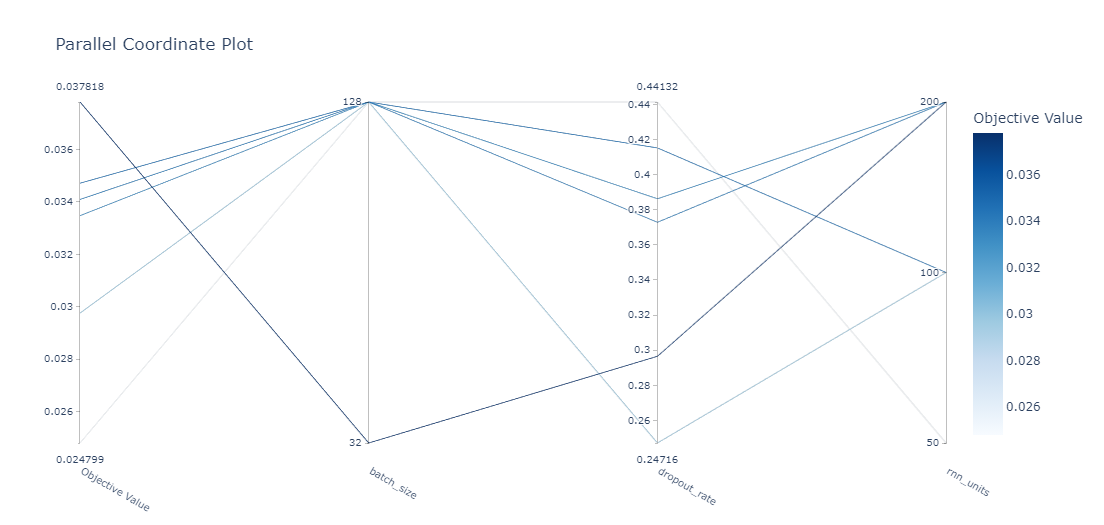

In [10]:
# Plot the correlation matrix between hyperparameters
vis.plot_slice(study)


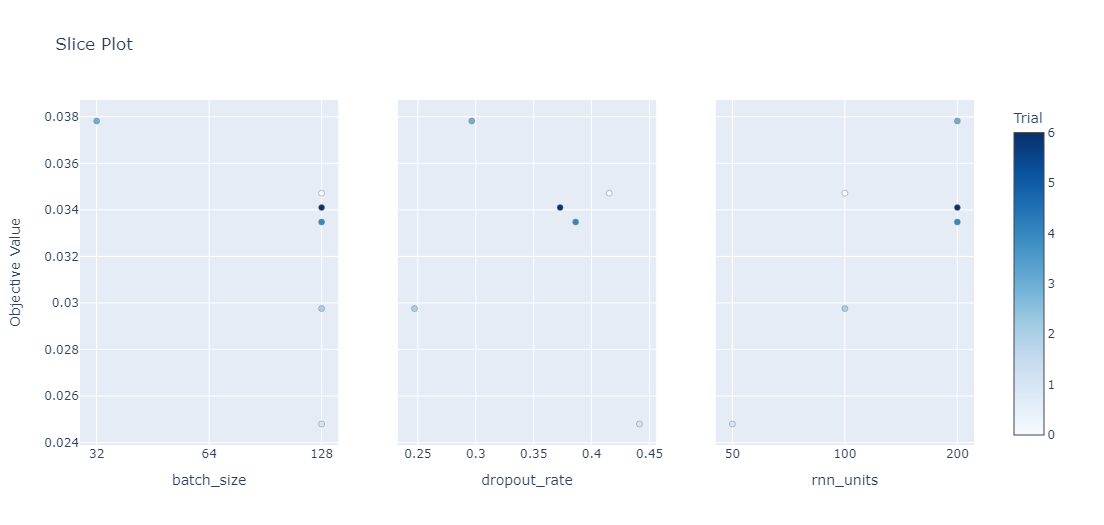

In [11]:
# Plot the hyperparameter importances
vis.plot_param_importances(study)

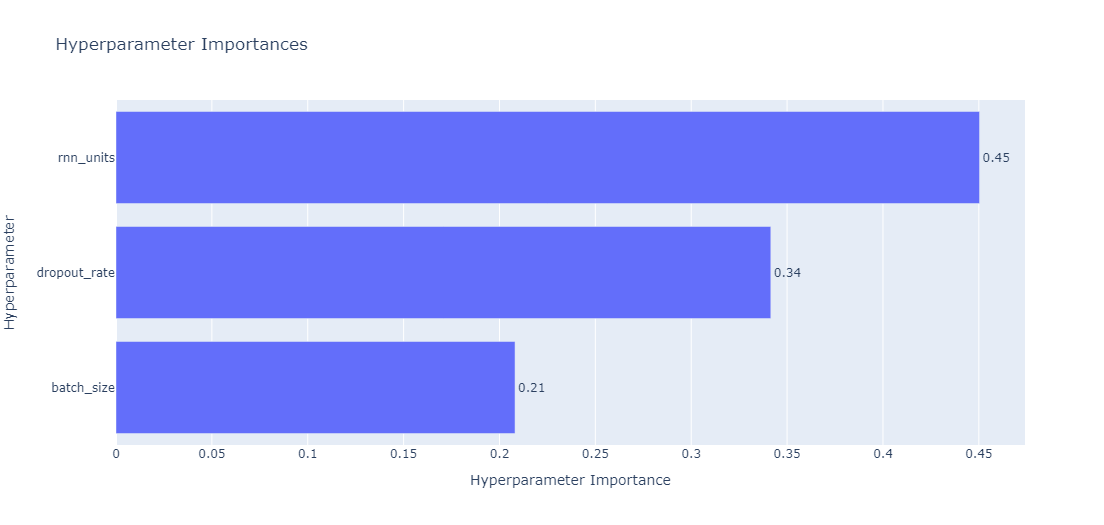

In [12]:
# Visualize the optimization process
vis.plot_optimization_history(study)


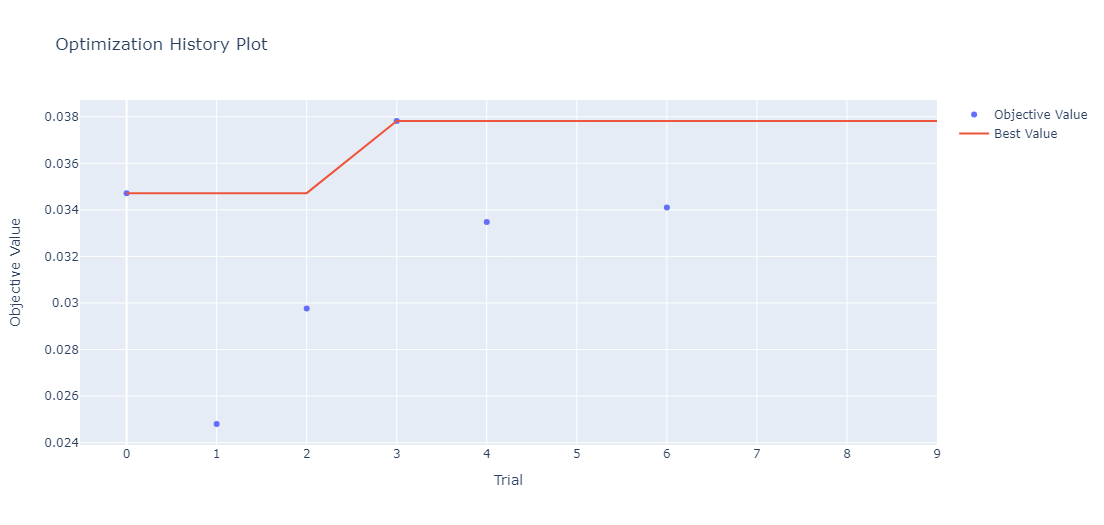

# Confusion Matrix

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predict the classes
y_pred = model.predict(predictors)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(label.argmax(axis=1), y_pred_classes)

# Print the confusion matrix
print(cm)


253/253 [==============================] - 3s 9ms/step
[[276   0   0 ...   0   0   0]
 [201   0   0 ...   0   0   0]
 [215   0   0 ...   0   0   0]
 ...
 [  1   0   0 ...   0   0   0]
 [  1   0   0 ...   0   0   0]
 [  1   0   0 ...   0   0   0]]


# The best Trial with the best Hyperparameters

In [15]:
best_trial = study.best_trial
print(f"Best trial number: {best_trial.number}")
print(f"Best parameters - RNN Units: {best_trial.params['rnn_units']}, Dropout Rate: {best_trial.params['dropout_rate']}, Batch Size: {best_trial.params['batch_size']}")
print(f"Best validation accuracy: {best_trial.value}")

Best trial number: 3
Best parameters - RNN Units: 200, Dropout Rate: 0.2965342018558983, Batch Size: 32
Best validation accuracy: 0.037817731499671936
